Following https://github.com/Azure/lstms_for_predictive_maintenance

The **training data** consists of multiple multivariate time series with "cycle" as the time unit, together with 21 sensor readings for each cycle. Each time series can be assumed as being generated from a different engine of the same type. When a predefined threshold is reached, then the engine is considered unsafe for further operation. In other words, the last cycle in each time series can be considered as the failure point of the corresponding engine. Taking the sample training data shown in the following table as an example, the engine with id=1 fails at cycle 192, and engine with id=2 fails at cycle 287.   

The **testing data** has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs. Taking the sample testing data shown in the following table as an example, the engine with id=1 runs from cycle 1 through cycle 31. It is not shown how many more cycles this engine can last before it fails.   

Finally, the **ground truth data** provides the number of remaining working cycles for the engines in the testing data. Eg. the engine with id=1 in the testing data can run another 112 cycles before it fails.

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

Using TensorFlow backend.


## Import the data

In [2]:
# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)   #extra empty space 
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [3]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [4]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [5]:
#train_df = train_df.sort_values(['id','cycle'])
train_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5   ...        s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62   ...     521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62   ...     522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62   ...     522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62   ...     522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62   ...     522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739  
4  38.90  23.4044  

[5 rows x 26 columns]

## Data Labeling

**Regression models**: How many more cycles an in-service engine will last before it fails?  
**Binary classification**: Is this engine going to fail within w1 cycles?  
**Multi-class classification**: Is this engine going to fail within the window [1, w0] cycles or to fail within the window [w0+1, w1] cycles, or it will not fail within w1 cycles?

"RUL", label1", and "label2" are labels for regression, binary classification, and multi-class classification models respectively. Here w0 and w1 are predefined use case related parameters which are used to label the training data. One needs to decide how far ahead of time the alert of failure should trigger before the actual failure event. 

In [6]:
(train_df.groupby('id')['cycle'].max()).head()

id
1    192
2    287
3    179
4    189
5    269
Name: cycle, dtype: int64

In [7]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

In [8]:
rul.head(3)

id  max
0   1  192
1   2  287
2   3  179

In [9]:
train_df = train_df.merge(rul, on='id', how='left')

In [10]:
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5 ...       s13      s14     s15   s16  s17   s18    s19    s20  \
0  14.62 ...   2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  14.62 ...   2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  14.62 ...   2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  14.62 ...   2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  14.62 ...   2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

       s21  RUL  
0  23.4190  191  
1  23.4236  190  
2  23.3442  189  
3  23.3739  188  
4  23.4044  187  

[5 rows x 27 columns]

In [11]:
w0 = 15
w1 = 30
train_df['label1'] = np.where(train_df['RUL']<=w1, 1, 0)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL']<=w0, 'label2'] = 2
train_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5   ...       s15   s16  s17   s18    s19    s20      s21  RUL  label1  \
0  14.62   ...    8.4195  0.03  392  2388  100.0  39.06  23.4190  191       0   
1  14.62   ...    8.4318  0.03  392  2388  100.0  39.00  23.4236  190       0   
2  14.62   ...    8.4178  0.03  390  2388  100.0  38.95  23.3442  189       0   
3  14.62   ...    8.3682  0.03  392  2388  100.0  38.88  23.3739  188       0   
4  14.62   ...    8.4294  0.03  393  2388  100.0  38.90  23.4044  187       0   

   label2  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 29 columns]

### MinMax Norm

In [12]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
no_norm_col = ['id','cycle','RUL','label1','label2']
norm_col    = train_df.columns.difference(no_norm_col)

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[norm_col]), 
                             columns=norm_col, 
                             index=train_df.index)

In [14]:
join_df = train_df[no_norm_col].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head(3)

id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.459770  0.166667       0.0  0.0  0.183735  0.406802  0.309757   
1   1      2  0.609195  0.250000       0.0  0.0  0.283133  0.453019  0.352633   
2   1      3  0.252874  0.750000       0.0  0.0  0.343373  0.369523  0.370527   

    s5     ...      s16       s17  s18  s19       s20       s21  RUL  label1  \
0  0.0     ...      0.0  0.333333  0.0  0.0  0.713178  0.724662  191       0   
1  0.0     ...      0.0  0.333333  0.0  0.0  0.666667  0.731014  190       0   
2  0.0     ...      0.0  0.166667  0.0  0.0  0.627907  0.621375  189       0   

   label2  cycle_norm  
0       0     0.00000  
1       0     0.00277  
2       0     0.00554  

[3 rows x 30 columns]

Normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [17]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[norm_col]), #no fit 
                            columns= norm_col, 
                            index=test_df.index)

test_join_df = test_df[test_df.columns.difference(norm_col)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)

In [18]:
test_df.head(3)

id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   

    s5     ...           s13       s14       s15  s16       s17  s18  s19  \
0  0.0     ...      0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0   
1  0.0     ...      0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0   
2  0.0     ...      0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0   

        s20       s21  cycle_norm  
0  0.558140  0.661834     0.00000  
1  0.682171  0.686827     0.00277  
2  0.728682  0.721348     0.00554  

[3 rows x 27 columns]

Use the ground truth dataset to generate labels for the test data.

In [19]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [20]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5 ...        s14       s15  s16       s17  s18  s19       s20       s21  \
0  0.0 ...   0.132160  0.308965  0.0  0.333333  0.0  0.0  0.558140  0.661834   
1  0.0 ...   0.204768  0.213159  0.0  0.416667  0.0  0.0  0.682171  0.686827   
2  0.0 ...   0.155640  0.458638  0.0  0.416667  0.0  0.0  0.728682  0.721348   
3  0.0 ...   0.170090  0.257022  0.0  0.250000  0.0  0.0  0.666667  0.662110   
4  0.0 ...   0.152751  0.300885  0.0  0.166667  0.0  0.0  0.658915  0.716377   

   cycle_norm  RUL  
0     0.00000  142  
1     0.00277  141  
2     0.00554  140  
3     0.00831  139  
4     0.01108  138  

[5 rows x 28 columns]

In [21]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head(3)

id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   

    s5   ...    s16       s17  s18  s19       s20       s21  cycle_norm  RUL  \
0  0.0   ...    0.0  0.333333  0.0  0.0  0.558140  0.661834     0.00000  142   
1  0.0   ...    0.0  0.416667  0.0  0.0  0.682171  0.686827     0.00277  141   
2  0.0   ...    0.0  0.416667  0.0  0.0  0.728682  0.721348     0.00554  140   

   label1  label2  
0       0       0  
1       0       0  
2       0       0  

[3 rows x 30 columns]

## View of Data

In [22]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

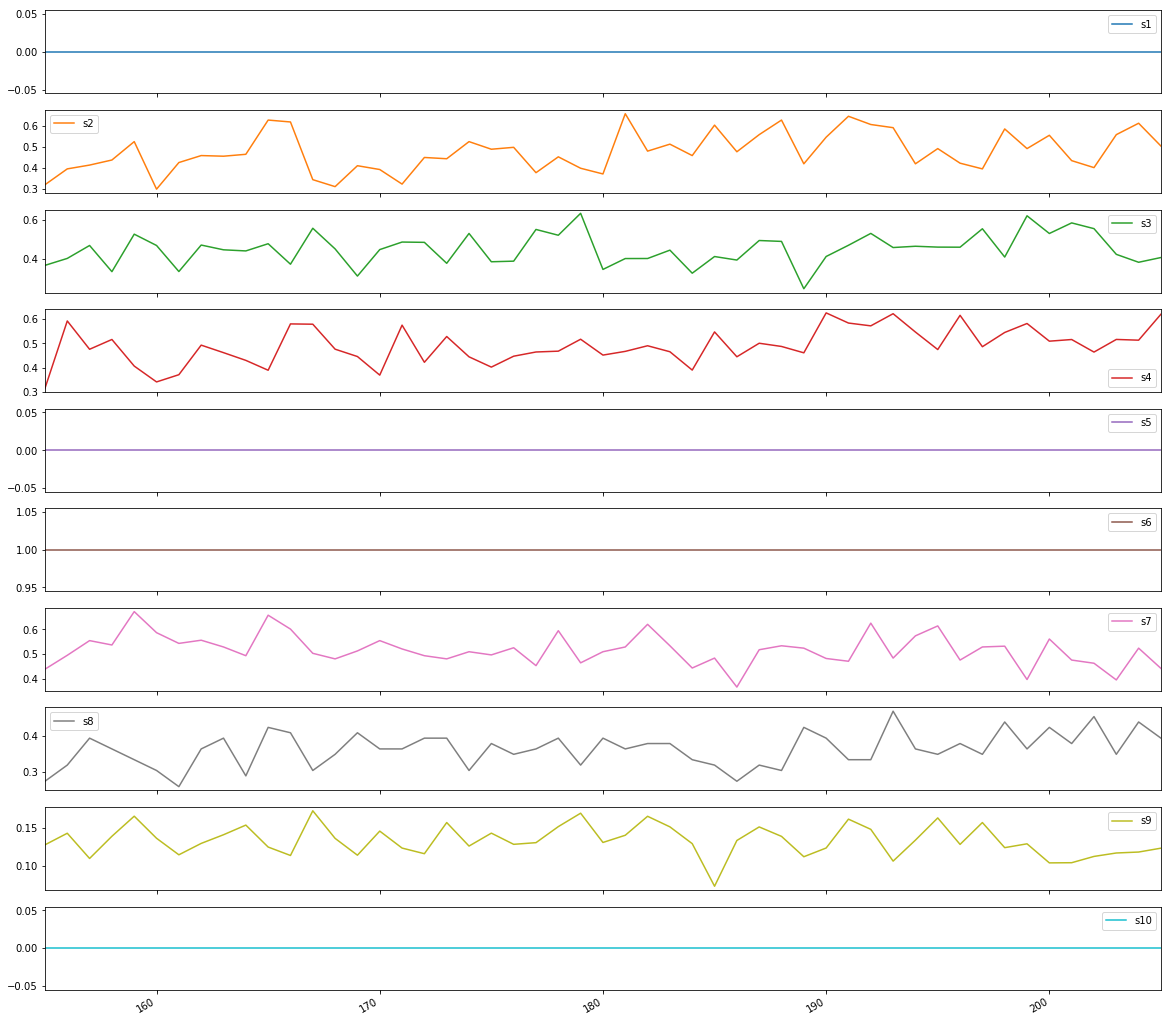

In [23]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

In [24]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

When using LSTMs in the time-series domain, one important parameter to pick is the sequence length which is the window for LSTMs to look back. This may be viewed as similar to picking window_size = 5 cycles for calculating the rolling features which are rolling mean and rolling standard deviation for 21 sensor values. The idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

In [25]:
# pick a large window size of 50 cycles
sequence_length = 50

In [26]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing we need to drop 
    those which are below the window-length. An alternative would be to pad sequences so that we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [27]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [34]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [32]:
# generate sequences (list of 100(id) arrays) and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

## Binary classification: 
Is this engine going to fail within w1 cycles?

### Generate labels

In [49]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [50]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]

In [54]:
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [55]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
%%time
# fit the network
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=2, mode='auto')])

Train on 14067 samples, validate on 1564 samples
Epoch 1/10
44s - loss: 0.2738 - acc: 0.8873 - val_loss: 0.1306 - val_acc: 0.9412
Epoch 2/10
37s - loss: 0.1049 - acc: 0.9568 - val_loss: 0.1083 - val_acc: 0.9495
Epoch 3/10
37s - loss: 0.0799 - acc: 0.9674 - val_loss: 0.0826 - val_acc: 0.9610
Epoch 4/10
37s - loss: 0.0801 - acc: 0.9667 - val_loss: 0.0602 - val_acc: 0.9674
Epoch 5/10
37s - loss: 0.0732 - acc: 0.9702 - val_loss: 0.0934 - val_acc: 0.9648
Epoch 00004: early stopping
Wall time: 3min 18s


### Performance on the training dataset

In [59]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

15600/15631 [============================>.] - ETA: 0sConfusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12495,    36],
       [  570,  2530]])

In [60]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

15600/15631 [============================>.] - ETA: 0sAccurracy: 0.9612308892306253
precision =  0.985970381917 
 recall =  0.816129032258


### Performance on the test dataset  
 pick the last sequence for each id in the test data.

In [70]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [71]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [75]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values

In [78]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [79]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

Accurracy: 0.9247311770275075


In [80]:
# make predictions and compute confusion matrix
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

93/93 [==============================] - 0s     
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [ 7, 18]])

In [81]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.72 
 F1-score: 0.837209302326


In [ ]:
## Binary classification: 